The purpose of the demo is to show a sample of ML capabilities in Viya VDMML using the jupyter interface. We create a **ML pipeline to train and compare models for an example supervised learning problem : churn detection**.

In this demo we will
1. First read data into a into a Pandas data frame on the client laptop
2. Then uploaded to the CAS server(s)
3. We'll then do some simple Data Manipulation steps to show SQL capabilities
4. Build Classification models (Both CAS & Open Source)
5. We'll do some Automated Model Training/Tuning
6. Assess Models
7. Compare their performance
8. Score Data in Batch

In [1]:
import swat,pygal
from _config import container_18wk47_login, container_19wk21_login,container_xl_19wk21_login
from swat.render import render_html
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
from matplotlib import pyplot as plt
from IPython.display import HTML
%matplotlib inline
from plotnine import *
import os, time
#os.environ['CAS_CLIENT_SSL_CA_LIST']=r'/ext_str/beast_trustfiles/nBeast_trustfiles/trustedcerts.pem'
from IPython.display import IFrame
%reload_ext autoreload
%autoreload 2

In [2]:
#Connect to the CAS Server

host = container_18wk47_login()[2]
user = container_18wk47_login()[0]
pswd = container_18wk47_login()[1]
conn = swat.CAS(host,5571,user,pswd)

# conn.about()

# conn = swat.CAS(login()[2],8777,login()[0],login()[1],protocol="http")
conn.setsessopt(caslib="casuser")

NOTE: 'CASUSER(sasdemo)' is now the active caslib.


+ Elapsed: 0.000644s, user: 0.000277s, sys: 0.000324s, mem: 0.225mb

Load Data into pandas and check out the columns

In [3]:
#Load the data set into a pandas dataframe
churn_df=pd.read_csv('churn.csv')
#Clean print column names
for i in churn_df.columns : print(i)

Account Length
VMail Message
Day Mins
Eve Mins
Night Mins
Intl Mins
CustServ Calls
Churn
Int'l Plan
VMail Plan
Day Calls
Day Charge
Eve Calls
Eve Charge
Night Calls
Night Charge
Intl Calls
Intl Charge
State
Area Code
Phone


Clearly, we want to rename some of these columns

In [4]:
#remove/replace special characters and white spaces
churn_df.columns = [i.replace(' ','_').replace("'",'').lower() for i in churn_df.columns]
#Check out how the resultant dataset look like
churn_df.head()

,account_length,vmail_message,day_mins,eve_mins,night_mins,intl_mins,custserv_calls,churn,intl_plan,vmail_plan,...,day_charge,eve_calls,eve_charge,night_calls,night_charge,intl_calls,intl_charge,state,area_code,phone
0,128,25,265.10,197.40,244.70,10.00,1,0,0,1,...,45.07,99,16.78,91,11.01,3,2.70,KS,415,382-4657
1,107,26,161.60,195.50,254.40,13.70,1,0,0,1,...,27.47,103,16.62,103,11.45,3,3.70,OH,415,371-7191
2,137,0,243.40,121.20,162.60,12.20,0,0,0,0,...,41.38,110,10.30,104,7.32,5,3.29,NJ,415,358-1921
3,84,0,299.40,61.90,196.90,6.60,2,0,1,0,...,50.90,88,5.26,89,8.86,7,1.78,OH,408,375-9999
4,75,0,166.70,148.30,186.90,10.10,3,0,1,0,...,28.34,122,12.61,121,8.41,3,2.73,OK,415,330-6626


Usually we would load data from database or the server side - or some distributed file system. For this example
**Load data into CAS from the client** and examine the resulting CASResults Object

In [5]:
out=conn.upload(churn_df,casout=dict(name='churn',caslib='casuser'))
out

NOTE: Cloud Analytic Services made the uploaded file available as table CHURN in caslib CASUSER(sasdemo).
NOTE: The table CHURN has been created in caslib CASUSER(sasdemo) from binary data uploaded to Cloud Analytic Services.


[caslib]

 'CASUSER(sasdemo)'

[tableName]

 'CHURN'

[casTable]

 CASTable('CHURN', caslib='CASUSER(sasdemo)')

+ Elapsed: 0.0203s, user: 0.0218s, sys: 0.00823s, mem: 18.1mb

Check out the CAS Table

In [6]:
out=out.casTable
render_html(out.fetch(to=5))

Selected Rows from Table CHURN 
 account_length 
 vmail_message 
 day_mins 
 eve_mins 
 night_mins 
 intl_mins 
 custserv_calls 
 churn 
 intl_plan 
 vmail_plan 
 day_calls 
 day_charge 
 eve_calls 
 eve_charge 
 night_calls 
 night_charge 
 intl_calls 
 intl_charge 
 state 
 area_code 
 phone 
 
 
 128 25 265.1 197.4 244.7 10 1 0 0 1 110 45.07 99 16.78 91 11.01 3 2.7 KS 415 382-4657 
 107 26 161.6 195.5 254.4 13.7 1 0 0 1 123 27.47 103 16.62 103 11.45 3 3.7 OH 415 371-7191 
 137 0 243.4 121.2 162.6 12.2 0 0 0 0 114 41.38 110 10.3 104 7.32 5 3.29 NJ 415 358-1921 
 84 0 299.4 61.9 196.9 6.6 2 0 1 0 71 50.9 88 5.26 89 8.86 7 1.78 OH 408 375-9999 
 75 0 166.7 148.3 186.9 10.1 3 0 1 0 113 28.34 122 12.61 121 8.41 3 2.73 OK 415 330-6626

In [8]:
out.dtypes

account_length     double
vmail_message      double
day_mins           double
eve_mins           double
night_mins         double
intl_mins          double
custserv_calls     double
churn              double
intl_plan          double
vmail_plan         double
day_calls          double
day_charge         double
eve_calls          double
eve_charge         double
night_calls        double
night_charge       double
intl_calls         double
intl_charge        double
state             varchar
area_code          double
phone             varchar
dtype: object

We notice two things that ought to be done here. The data type for `churn` and `area_code` variables should not be double. Let's change that by using some SQL on the in memory table. 

In [9]:
#Enable SQL actions - for distributed SQL
conn.loadactionset('fedSQL')

#programmatically build query
col_list= [i for i in out.columns if i not in ('area_code','churn','intl_plan','vmail_plan')]
cas_lib='casuser'
option_params='{options replace=true}'
query = """create table {}.churn {} as select {}, 
cast(intl_plan as char) as intl_plan,
cast(vmail_plan as char) as vmail_plan,
cast(area_code as varchar) as area_code,
cast(churn as varchar) as churn
from casuser.churn """.format(cas_lib,
                              option_params,
                              col_list).replace('[','').replace(']','').replace("'",'')
print(query)

NOTE: Added action set 'fedSQL'.
create table casuser.churn {options replace=true} as select account_length, vmail_message, day_mins, eve_mins, night_mins, intl_mins, custserv_calls, day_calls, day_charge, eve_calls, eve_charge, night_calls, night_charge, intl_calls, intl_charge, state, phone, 
cast(intl_plan as char) as intl_plan,
cast(vmail_plan as char) as vmail_plan,
cast(area_code as varchar) as area_code,
cast(churn as varchar) as churn
from casuser.churn 


In [10]:
#execute query and check the results
conn.fedsql.execdirect(query) # run the query
out = conn.CASTable('CHURN', caslib ='casuser') #get the results
render_html(out.fetch(to=5)) #view the results

NOTE: Table CHURN was created in caslib CASUSER(sasdemo) with 3333 rows returned.


Selected Rows from Table CHURN 
 account_length 
 vmail_message 
 day_mins 
 eve_mins 
 night_mins 
 intl_mins 
 custserv_calls 
 day_calls 
 day_charge 
 eve_calls 
 eve_charge 
 night_calls 
 night_charge 
 intl_calls 
 intl_charge 
 state 
 phone 
 INTL_PLAN 
 VMAIL_PLAN 
 AREA_CODE 
 CHURN 
 
 
 128 25 265.1 197.4 244.7 10 1 110 45.07 99 16.78 91 11.01 3 2.7 KS 382-4657 0 1 415 0 
 107 26 161.6 195.5 254.4 13.7 1 123 27.47 103 16.62 103 11.45 3 3.7 OH 371-7191 0 1 415 0 
 137 0 243.4 121.2 162.6 12.2 0 114 41.38 110 10.3 104 7.32 5 3.29 NJ 358-1921 0 0 415 0 
 84 0 299.4 61.9 196.9 6.6 2 71 50.9 88 5.26 89 8.86 7 1.78 OH 375-9999 1 0 408 0 
 75 0 166.7 148.3 186.9 10.1 3 113 28.34 122 12.61 121 8.41 3 2.73 OK 330-6626 1 0 415 0

In [10]:
# To save the file to the filesystem
#conn.table.save(table='CHURN', name='churn_opt.csv')

 <font size=2px> **Quick Side note** :- Nothing stops you from doing this - You can get fancy and write your own python helpers for anything on CAS like the example below which custom combines two actions together:-
```python
def _load_actionset_not_loaded(action_set='whatsavailable'):
"""Check the action sets, if the action set asked for is available, load it. If it is already loaded - print that message.If its not available - show all action sets available"""
    loaded_action_sets=conn.actionsetinfo(all=True).setinfo[['actionset','loaded']]
    if len(loaded_action_sets[(loaded_action_sets['actionset']==action_set) &
                          (loaded_action_sets['loaded']==1)])>0:
        print('{} action set was already loaded'. format(action_set))
    elif len(loaded_action_sets[(loaded_action_sets['actionset']==action_set)])>0:
        print('You are licensed for that action set')
        conn.loadactionset(action_set)
        print('{} action set was loaded'.format(action_set))
    else:
        print('Cant recognize actionset name')
        print('Here is a list of all possible action sets')
        return conn.actionsetinfo(all=True).setinfo
_load_actionset_not_loaded('test')
```

**Explore Data**

Next we can do a quick exploration by performing group-bys

In [12]:
grpsumm=out.groupby('churn').summary()
comb_group_summ = grpsumm.concat_bygroups()
combined_summary = comb_group_summ['Summary']
combined_summary.sort_values(by=['Column'])

,Column,Min,Max,N,NMiss,Mean,Sum,Std,StdErr,Var,USS,CSS,CV,TValue,ProbT,Skewness,Kurtosis
CHURN,,,,,,,,,,,,,,,,,
0,account_length,1.00,243.00,2850.00,0.00,100.79,287262.00,39.88,0.75,1590.60,33485820.00,4531624.69,39.57,134.92,0.00,0.09,-0.13
1,account_length,1.00,225.00,483.00,0.00,102.66,49587.00,39.47,1.80,1557.71,5841645.00,750815.66,38.44,57.17,0.00,0.14,0.06
1,custserv_calls,0.00,9.00,483.00,0.00,2.23,1077.00,1.85,0.08,3.43,4057.00,1655.49,83.11,26.44,0.00,0.70,-0.10
0,custserv_calls,0.00,8.00,2850.00,0.00,1.45,4132.00,1.16,0.02,1.35,9850.00,3859.32,80.28,66.50,0.00,0.89,1.21
1,day_calls,0.00,165.00,483.00,0.00,101.34,48945.00,21.58,0.98,465.80,5184375.00,224513.66,21.30,103.19,0.00,-0.35,0.73
0,day_calls,0.00,163.00,2850.00,0.00,100.28,285807.00,19.80,0.37,392.09,29778681.00,1117052.49,19.75,270.37,0.00,-0.06,0.13
0,day_charge,0.00,53.65,2850.00,0.00,29.78,84874.20,8.53,0.16,72.78,2734925.83,207336.41,28.65,186.36,0.00,-0.23,-0.00
1,day_charge,0.00,59.64,483.00,0.00,35.18,16989.97,11.73,0.53,137.59,663954.35,66316.50,33.35,65.91,0.00,-0.20,-0.81
0,day_mins,0.00,315.60,2850.00,0.00,175.18,499250.90,50.18,0.94,2518.20,94631000.61,7174347.57,28.65,186.36,0.00,-0.23,-0.00


Or, if you prefer visually scanning through data here's an example of a neat plot for visualization or you could simply get a pandas barplot

In [13]:
# Hand Crafted Metric for Feature Visualization  
radar_chart=pygal.Radar(style=pygal.style.DefaultStyle,include_x_axis=False)
radar_chart.title='Quick Feature Comparison - By Group Differences - Sq.Logged Mean Values'
radar_chart.x_labels=sorted(list(combined_summary['Column'].unique()))
radar_chart.add('Non-Churners',list(round(np.log(grpsumm['ByGroup1.Summary'][['Column','Mean']]
                                    .sort_values(by=['Column'])['Mean'])**2,1)))
radar_chart.add('Churners',list(round(np.log(grpsumm['ByGroup2.Summary'][['Column','Mean']]
                                    .sort_values(by=['Column'])['Mean'])**2,1)))
radar_chart.render_to_file('charts/radar.svg')
IFrame(width=800, height=800, frameBorder=0, src="charts/radar.svg")

In [22]:
# for i in comb_group_summ['Summary']['Column'].unique():
#     plt.figure()
#     combined_summary[combined_summary['Column']==i]['Mean'].plot(kind='barh', color='teal').set_title(i);
#     plt.show()

You can also get a traditional `ggplot` viz going, by sampling from the server side data (if you data is too big)

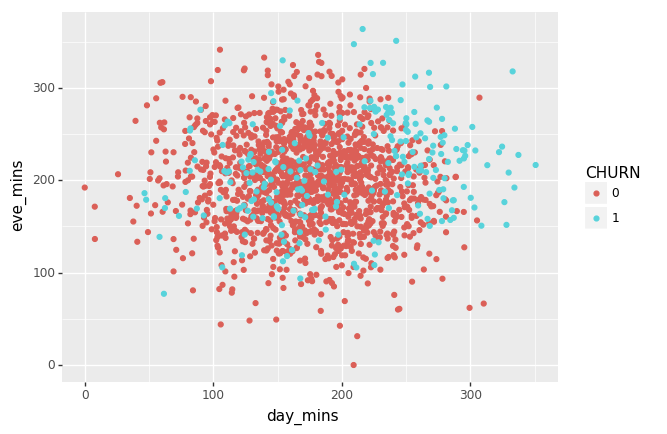

<ggplot: (-9223363292243224025)>

In [14]:
#Sample data and plot
ex=out[['day_mins','eve_mins','CHURN']].to_frame(sample_pct=.5,stratify_by='CHURN')
ggplot(ex,aes(x='day_mins',y='eve_mins',color='CHURN')) + geom_point()

Ok, we've seen some data manipulations, visualizations, lets do some **<font color=green> machine learning!</font>**

In [16]:
#As usual, load the action sets
conn.loadactionset(actionset="sampling")
conn.loadactionset(actionset="regression")
conn.loadactionset(actionset="autotune")
conn.loadactionset(actionset="decisionTree")

NOTE: Added action set 'sampling'.
NOTE: Added action set 'regression'.
NOTE: Added action set 'autotune'.
NOTE: Added action set 'decisionTree'.


[actionset]

 'decisionTree'

+ Elapsed: 0.00509s, user: 0.00127s, sys: 0.00378s, mem: 0.195mb

Apply a sampling scheme - we'll use stratified sampling and also return partition indicators

In [18]:
#Conduct Sampling and see the data set
out_smpl=conn.sampling.stratified(
  table={"name":"CHURN", "groupby":'churn'},
  output={"casout":{"name":"churn_part", "replace":True}, "copyvars":"ALL"},
  samppct=70,
  partind=True
)
render_html(conn.CASTable('churn_part').head())

NOTE: Using SEED=1450534425 for sampling.


Selected Rows from Table CHURN_PART 
 account_length 
 vmail_message 
 day_mins 
 eve_mins 
 night_mins 
 intl_mins 
 custserv_calls 
 day_calls 
 day_charge 
 eve_calls 
 eve_charge 
 night_calls 
 night_charge 
 intl_calls 
 intl_charge 
 state 
 phone 
 INTL_PLAN 
 VMAIL_PLAN 
 AREA_CODE 
 CHURN 
 Partition Indicator 
 
 
 128 25 265.1 197.4 244.7 10 1 110 45.07 99 16.78 91 11.01 3 2.7 KS 382-4657 0 1 415 0 0 
 107 26 161.6 195.5 254.4 13.7 1 123 27.47 103 16.62 103 11.45 3 3.7 OH 371-7191 0 1 415 0 1 
 137 0 243.4 121.2 162.6 12.2 0 114 41.38 110 10.3 104 7.32 5 3.29 NJ 358-1921 0 0 415 0 1 
 84 0 299.4 61.9 196.9 6.6 2 71 50.9 88 5.26 89 8.86 7 1.78 OH 375-9999 1 0 408 0 1 
 75 0 166.7 148.3 186.9 10.1 3 113 28.34 122 12.61 121 8.41 3 2.73 OK 330-6626 1 0 415 0 0

Next let's characterize our variables. Put them into sets or lists (basically sequence types that we can pass as arguments to the ML action calls later). Once again - you can get fancy with an expression or call out the variables

In [19]:
#intialize var sets
noms={'area_code','churn','intl_plan','vmail_plan'}
int_vars={'account_length', 'custserv_calls', 'day_calls', 'day_charge', 'day_mins', 'eve_calls',
          'eve_charge', 'eve_mins', 'intl_calls', 'intl_charge', 'intl_mins', 
          'night_calls','night_charge', 'night_mins', 'vmail_message', }
effect_vars={'area_code','account_length', 'custserv_calls', 'day_calls', 'day_charge', 
             'day_mins', 'eve_calls','eve_charge', 'eve_mins', 'intl_calls', 
             'intl_charge', 'intl_mins', 'intl_plan','night_calls','night_charge',
             'night_mins', 'vmail_message', 'vmail_plan'}
#you can also easily set these variables up using expression like so -
#int_vars={i for i in cpart.dtypes[cpart.dtypes=='double'].index if i!='_PartInd_'}

In [20]:
cpart = conn.CASTable('CHURN_PART') #reference the partitioned CAS Table
#Run Logistic Regression-- Please note that many of those keyword arguments passed are optional
#Its used here just to demonstrate flexibility
log_reg = cpart.logistic(class_=[dict(vars=noms)],
                                   model={"depvars":[{"name":"churn", "options":{"event":"1"}}],
                                        "effects":[dict(vars=effect_vars)]
                                         },
                                   partbyvar={"name": "_partind_", "train": "1", "valid": "0"},
                                   selection=dict(method="stepwise"),
                                   output=dict(casout=dict(name="scored_logistic_data",
                                                          replace=True),
                                              copyvars="ALL")
                                  )

render_html(log_reg)
#if a particular portion of the result is needed something like this can be done as well
#log_reg['SelectedModel.ParameterEstimates']

NOTE: Convergence criterion (GCONV=1E-8) satisfied.


Model Information 
 RowId 
 Description 
 Value 
 
 
 DATA Data Source CHURN_PART 
 RESPONSEVAR Response Variable CHURN 
 DIST Distribution Binary 
 LINK Link Function Logit 
 TECH Optimization Technique Newton-Raphson with Ridging 
 
 
 
 
 Number of Observations 
 RowId 
 Description 
 Total 
 Training 
 Validation 
 
 
 NREAD Number of Observations Read 3333 2333 1000 
 NUSED Number of Observations Used 3333 2333 1000 
 
 
 
 
 Response Profile 
 Ordered Value 
 CHURN 
 CHURN 
 Total Frequency 
 Training 
 Validation 
 Probability Modeled 
 
 
 1 0 0 2850 1995 855 
 2 1 1 483 338 145 * 
 
 
 
 
 Class Level Information 
 Class 
 Levels 
 Values 
 
 
 INTL_PLAN 2 0 1 
 VMAIL_PLAN 2 0 1 
 AREA_CODE 3 408 415 510 
 
 
 
 
 Selection Information 
 RowId 
 Description 
 Value 
 Numeric Value 
 
 
 METHOD Selection Method Stepwise nan 
 SELCRITERION Select Criterion SBC nan 
 STOPCRITERION Stop Criterion SBC nan 
 HIERARCHY Effect Hierarchy Enforced None nan 
 STOPHORIZON Stop Horizon 3 3 
 
 
 
 
 Convergence Status 
 Reason 
 Status 
 Max Gradient 
 
 
 Convergence criterion (GCONV=1E-8) satisfied. 0 3.390474E-10 
 
 
 
 
 Selection Summary 
 Control 
 Step 
 Effect Entered 
 Effect Removed 
 Number Of Effects 
 SBC 
 Optimal SBC 
 
 
 0 Intercept 1 1938.1738902 0 
 - 1 INTL_PLAN 2 1766.6902113 0 
 2 custserv_calls 3 1703.9899821 0 
 3 day_mins 4 1637.6562848 0 
 4 VMAIL_PLAN 5 1620.9780786 0 
 5 eve_mins 6 1605.5787338 0 
 6 intl_charge 7 1599.8017278 1 
 
 
 
 
 Stop Reason 
 Reason 
 Code 
 
 
 Stepwise selection stopped because adding or removing an effect does not improve the SBC criterion. 8 
 
 
 
 
 Selection Reason 
 Reason 
 
 
 The model at step 6 is selected. 
 
 
 
 
 Selected Effects 
 Label 
 Effects 
 
 
 Selected Effects: Intercept eve_mins intl_charge custserv_calls day_mins INTL_PLAN VMAIL_PLAN 
 
 
 
 
 Dimensions 
 RowId 
 Description 
 Value 
 
 
 NDESIGNCOLS Columns in Design 9 
 NEFFECTS Number of Effects 7 
 MAXEFCOLS Max Effect Columns 2 
 DESIGNRANK Rank of Design 7 
 OPTPARM Parameters in Optimization 7 
 
 
 
 
 Likelihood Ratio Test 
 Test 
 DF 
 Chi-Square 
 Pr > ChiSq 
 
 
 Likelihood Ratio 6 385.10453599 4.448265E-80 
 
 
 
 
 Fit Statistics 
 RowId 
 Description 
 Training 
 Validation 
 
 
 M2LL -2 Log Likelihood 1545.3144439 647.99322526 
 AIC AIC (smaller is better) 1559.3144439 661.99322526 
 AICC AICC (smaller is better) 1559.362616 662.10612849 
 SBC SBC (smaller is better) 1599.5988158 696.34751221 
 ASE Average Square Error 0.1019348838 0.0983798237 
 M2LLNULL -2 Log L (Intercept-only) 1930.4189799 827.87426078 
 RSQUARE R-Square 0.1521642749 0.1646304152 
 ADJRSQ Max-rescaled R-Square 0.2703540866 0.292404526 
 MCFADDEN McFadden's R-Square 0.1994927215 0.2172806235 
 MISCLASS Misclassification Rate 0.1418774111 0.135 
 DIFFMEAN Difference of Means 0.1870192156 0.2139807679 
 
 
 
 
 Parameter Estimates 
 Effect 
 INTL_PLAN 
 VMAIL_PLAN 
 Parameter 
 Parameter 
 DF 
 Estimate 
 Standard Error 
 Chi-Square 
 Pr > ChiSq 
 
 
 Intercept Intercept Intercept 1 -6.02756398 0.5387504433 125.17234168 4.666104E-29 
 eve_mins eve_mins eve_mins 1 0.0064213413 0.0013448653 22.797852185 1.7996672E-6 
 intl_charge intl_charge intl_charge 1 0.3237785006 0.0887012506 13.324058434 0.0002620224 
 custserv_calls custserv_calls custserv_calls 1 0.5100086208 0.0460849091 122.47221281 1.819457E-28 
 day_mins day_mins day_mins 1 0.0116806597 0.0012624239 85.609969883 2.191676E-20 
 INTL_PLAN 0 INTL_PLAN 0 INTL_PLAN_0 1 -2.085671528 0.1680995389 153.94258717 2.383833E-35 
 INTL_PLAN 1 INTL_PLAN 1 INTL_PLAN_1 0 0 nan nan nan 
 VMAIL_PLAN 0 VMAIL_PLAN 0 VMAIL_PLAN_0 1 0.8243117637 0.1665938761 24.483016748 7.4967739E-7 
 VMAIL_PLAN 1 VMAIL_PLAN 1 VMAIL_PLAN_1 0 0 nan nan nan 
 
 
 
 
 Task Timing 
 RowId 
 Task 
 Time 
 Relative Time 
 
 
 SETUP Setup and Parsing 0.006690979 0.0458660269 
 LEVELIZATION Levelization 0.0036840439 0.0252537716 
 INITIALIZATION Model Initialization 0.0012450218 0.0085345066 
 SSCP S

Obviously,you can also **<font color='green'>run SAS data step</font>** code to create new variables!

In [21]:
# Compute _pred0_ variable (1-_pred_)
conn.dataStep.runCode(
  code="data scored_logistic_data; set scored_logistic_data; _pred0_=1-_pred_; run;"
)

[InputCasTables]

              casLib                  Name  Rows  Columns  \
 0  CASUSER(sasdemo)  scored_logistic_data  3333       23   
 
                                             casTable  
 0  CASTable('scored_logistic_data', caslib='CASUS...  

[OutputCasTables]

              casLib                  Name  Rows  Columns  Append  \
 0  CASUSER(sasdemo)  scored_logistic_data  3333       24     nan   
 
                                             casTable  
 0  CASTable('scored_logistic_data', caslib='CASUS...  

+ Elapsed: 0.0195s, user: 0.0196s, sys: 0.0212s, mem: 4.43mb

Next, **Random Forest Model**

In [22]:
#Model Training - 
##1.Train the model on the training data
##2.Get important variables
##3. Write the model definition into a table
r_forest=cpart[cpart['_PartInd_']==1].decisiontree.foresttrain(
                                                               nominals=noms,
                                                               inputs=effect_vars,
                                                               target="churn",
                                                               varimp=True,
                                                               event='1',
                                                              casout=dict(name="rf_model", caslib="casuser",
                                                              replace=True),
                                                              savestate=dict(name='forest_model_train',
                                                                             replace=True))

r_forest #look at the results

NOTE: Wrote 784876 bytes to the savestate file forest_model_train.


,Descr,Value
0,Number of Trees,50.00
1,Number of Selected Variables (M),5.00
2,Random Number Seed,0.00
3,Bootstrap Percentage (%),63.21
4,Number of Bins,20.00
5,Number of Variables,18.00
6,Confidence Level for Pruning,0.25
7,Max Number of Tree Nodes,33.00
8,Min Number of Tree Nodes,13.00
9,Max Number of Branches,2.00


Model scoring is simple!

In [23]:
#Model Scoring
cpart.forestscore(modeltable='rf_model',
                 casout=dict(name="scored_rf_data",
                             replace=True, caslib='casuser'),
                 copyVars={"churn","_partind_"},
                  vote="PROB")

[OutputCasTables]

              casLib            Name  Rows  Columns  \
 0  CASUSER(sasdemo)  scored_rf_data  3333        7   
 
                                             casTable  
 0  CASTable('scored_rf_data', caslib='CASUSER(sas...  

[ScoreInfo]

                          Descr                             Value
 0  Number of Observations Read                              3333
 1  Number of Observations Used                              3333
 2  Misclassification Error (%)                      10.921092109

+ Elapsed: 0.0348s, user: 0.0874s, sys: 0.00165s, mem: 18.3mb

In [24]:
conn.fedsql.execdirect("""create table casuser.scored_rf_data {options replace=true} as
                       (select *,
                       case when _rf_predname_=1 then _rf_predp_ else 1-_rf_predp_ end as _pred_,
                       case when _rf_predname_=0 then _rf_predp_ else 1-_rf_predp_ end as _pred0_
                       from scored_rf_data
                       )
                       """)

#sneak peek at the data
dat=conn.CASTable('scored_rf_data')
dat[dat['_RF_PredName_']>0].head() #show me some churn events

NOTE: Table SCORED_RF_DATA was created in caslib CASUSER(sasdemo) with 3333 rows returned.


,CHURN,_PartInd_,_RF_PredName_,_RF_PredP_,_RF_PredLevel_,_MissIt_,_Vote_,_PRED_,_PRED0_
0,1,0.00,1,0.92,1.00,0.00,46.21,0.92,0.08
1,1,1.00,1,0.61,1.00,0.00,30.38,0.61,0.39
2,1,1.00,1,0.54,1.00,0.00,27.21,0.54,0.46
3,1,1.00,1,0.56,1.00,0.00,27.95,0.56,0.44
4,1,1.00,1,0.98,1.00,0.00,49.00,0.98,0.02


**Now, Let's try some auto tuning**

In [25]:
from rpart_tuner import recursive_partitioning_tuner
tree_factory = ['auto_tree','auto_forest','auto_gradboost']
## We care about this section the most ##
tuning_results = recursive_partitioning_tuner(conn=conn, input_table = cpart,
                                              inputs = effect_vars,
                                              nominals = noms,
                                              target = "churn", 
                                              autotune_factory = tree_factory)

NOTE: Autotune is started for 'Decision Tree' model.
NOTE: Autotune option SEARCHMETHOD='GA'.
NOTE: Autotune option MAXEVALS=50.
NOTE: Autotune option MAXTIME=36000 (sec.).
NOTE: Autotune option SEED=54321.
NOTE: Autotune objective is 'Misclassification Error Percentage'.
NOTE: Autotune number of parallel evaluations is set to 4, each using 0 worker nodes.
         Iteration       Evals     Best Objective        Time
                 0           1                6.9        0.18
                 1          10                5.4        2.79
                 2          19                5.4        5.03
                 3          28                5.4        8.62
                 4          37                5.4       10.45
                 5          46                5.4       12.42
NOTE: Data was partitioned during tuning, to tune based on validation score; the final model is trained and scored on all data.
NOTE: Autotune time is 14.58 seconds.
NOTE: Autotune is started for 'Forest' mo

Explore the results of the auto-tuning process by model type

In [26]:
total_evaluations_by_CAS_AutoTuner = 0
for i in tuning_results.keys():
    tuned_configurations = tuning_results[i]["TunerSummary"][tuning_results[i]
            ["TunerSummary"]["Parameter"]=="Number of Evaluated Configurations"]["Value"]
    total_evaluations_by_CAS_AutoTuner += tuned_configurations
print(f"""A total of {int(total_evaluations_by_CAS_AutoTuner)} tuning configurations were tested by CAS across models""")

A total of 138 tuning configurations were tested by CAS across models


In [27]:
tuning_results["gradboost"]

,Descr,Value
0,Number of Trees,35.00
1,Distribution,2.00
2,Learning Rate,0.20
3,Subsampling Rate,0.65
4,Number of Selected Variables (M),9.00
5,Number of Bins,20.00
6,Number of Variables,18.00
7,Max Number of Tree Nodes,61.00
8,Min Number of Tree Nodes,19.00
9,Max Number of Branches,2.00


In [28]:
from rpart_tuner import collect_scored_data
copy_vars = {"churn","_partind_"}
model_tables = [i  for i in conn.tableinfo()["TableInfo"]["Name"] if "auto" in i.lower() and "model" in i.lower()]
auto_score_results = collect_scored_data(conn,model_tables,cpart,copy_vars)

NOTE: Table AUTO_TREE_DATA was created in caslib CASUSER(sasdemo) with 3333 rows returned.
NOTE: Table AUTO_FOREST_DATA was created in caslib CASUSER(sasdemo) with 3333 rows returned.
NOTE: Table AUTO_GRADBOOST_DATA was created in caslib CASUSER(sasdemo) with 3333 rows returned.


In [29]:
auto_score_results["FOREST"]

[OutputCasTables]

              casLib              Name  Rows  Columns  \
 0  CASUSER(sasdemo)  AUTO_FOREST_DATA  3333        7   
 
                                             casTable  
 0  CASTable('AUTO_FOREST_DATA', caslib='CASUSER(s...  

[ScoreInfo]

                          Descr                             Value
 0  Number of Observations Read                              3333
 1  Number of Observations Used                              3333
 2  Misclassification Error (%)                      3.3903390339

+ Elapsed: 0.18s, user: 0.791s, mem: 43.7mb

We'll use the tables above to assess the model on the validation data set.
We'll do this for all the models we built

In [30]:
#Simple Pandas Style Subsetting to create validation data references for both Log Reg and RF
#get a CASTable Ref
scored_data_log=conn.CASTable('scored_logistic_data')
scored_data_forest=conn.CASTable('scored_rf_data')
auto_forest_data = conn.CASTable("AUTO_FOREST_DATA")
auto_gradboost_data = conn.CASTable("AUTO_GRADBOOST_DATA")
auto_tree_data = conn.CASTable("AUTO_TREE_DATA")
#Easy subsetting
valid_data_logistic=scored_data_log[scored_data_log['_PartInd_']==0]  #subset for Log Reg
valid_data_rf =scored_data_forest[scored_data_forest['_PartInd_']==0] #subset for RF

#for AutoTuned Models
valid_data_auto_forest=auto_forest_data[auto_forest_data['_PartInd_']==0] 
valid_data_auto_gradboost =auto_gradboost_data[auto_gradboost_data['_PartInd_']==0]
valid_data_auto_tree = auto_tree_data[auto_tree_data['_PartInd_']==0]

Helper function for model assessment - it generates and collects the validation metrics

In [31]:
def assess_model(validation_dataset):
    """This funtion calls the assessment action with the appropriate settings
    on the dataset passed"""
    return validation_dataset.assess(
      inputs=[{"name":"_pred_"}],      
      response="churn",
      event="1",
      pVar={"_pred0_"},
      pEvent={"0"}      
    )

Only Pick Up metrics we care about

In [32]:
#Pick up all assessmet Metrics
logistic_assess=assess_model(validation_dataset=valid_data_logistic)    
logistic_fitstat =logistic_assess.FitStat
logistic_rocinfo =logistic_assess.ROCInfo
logistic_liftinfo=logistic_assess.LIFTInfo

rf_assess=assess_model(validation_dataset=valid_data_rf)    
rf_fitstat =rf_assess.FitStat
rf_rocinfo =rf_assess.ROCInfo
rf_liftinfo=rf_assess.LIFTInfo

auto_forest_asses = assess_model(validation_dataset=valid_data_auto_forest)
auto_forest_fitstat = auto_forest_asses.FitStat
auto_forest_rocinfo = auto_forest_asses.ROCInfo
auto_forest_lift_info = auto_forest_asses.LIFTInfo

auto_gradboost_asses = assess_model(validation_dataset=valid_data_auto_gradboost)
auto_gradboost_fitstat = auto_gradboost_asses.FitStat
auto_gradboost_rocinfo = auto_gradboost_asses.ROCInfo
auto_gradboost_lift_info = auto_gradboost_asses.LIFTInfo

auto_tree_asses = assess_model(validation_dataset=valid_data_auto_tree)
auto_tree_fitstat = auto_tree_asses.FitStat
auto_tree_rocinfo = auto_tree_asses.ROCInfo
auto_tree_lift_info = auto_tree_asses.LIFTInfo

Some final simple data prep work for model assessment - also note,at this point eveything is happening on the client side

In [33]:
# Add new variable to indicate type of model
logistic_liftinfo["model"]="Logistic Regression"
logistic_rocinfo["model"]="Logistic Regression"
rf_liftinfo["model"]="Forest"
rf_rocinfo["model"]="Forest"

auto_forest_lift_info["model"] = "Auto-Forest"
auto_forest_rocinfo["model"] = "Auto-Forest"

auto_tree_lift_info["model"] = "Auto-Tree"
auto_tree_rocinfo["model"] = "Auto-Tree"

auto_gradboost_lift_info["model"] = "Auto-GradBoost"
auto_gradboost_rocinfo["model"] = "Auto-Gradboost"


all_liftinfo = pd.concat([rf_liftinfo,logistic_liftinfo,auto_forest_lift_info,
                         auto_gradboost_lift_info, auto_tree_lift_info])


all_rocinfo = pd.concat([rf_rocinfo,logistic_rocinfo,auto_forest_rocinfo,
                         auto_gradboost_rocinfo, auto_tree_rocinfo])

all_rocinfo.to_csv("ml_exercise.csv",index=False)
# #Get lift and ROC info together
# all_liftinfo=rf_liftinfo.append(logistic_liftinfo, ignore_index=True)
# all_rocinfo=rf_rocinfo.append(logistic_rocinfo, ignore_index=True)

And, the metrics we care about AUC, the ROC Curve and the lift chart..

In [34]:
print("AUC (using validation data)".center(80, '-'))
cas_models_summary = all_rocinfo[["model", "C"]].drop_duplicates(keep="first").sort_values(by="C", ascending=False)
cas_models_summary

--------------------------AUC (using validation data)---------------------------


,model,C
0,Auto-Tree,0.99
0,Auto-Gradboost,0.98
0,Auto-Forest,0.96
0,Forest,0.83
0,Logistic Regression,0.82


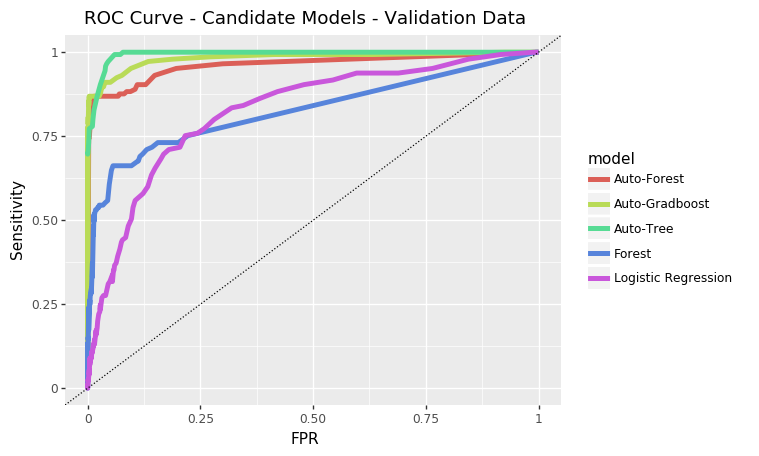

<ggplot: (8744610555235)>

In [35]:
#model_groups=all_rocinfo.groupby('model')
ggplot(all_rocinfo, aes(x='FPR', y='Sensitivity',color='model')) +\
    geom_line(linetype='solid',size=2) +\
    geom_abline(linetype='dotted') +\
    ggtitle('ROC Curve - Candidate Models - Validation Data') +\
    ylim(0,1) + xlim(0,1)

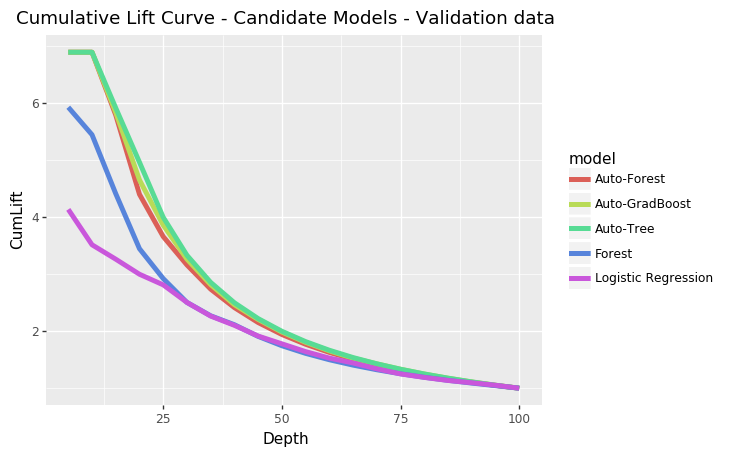

<ggplot: (-9223363292244276750)>

In [36]:
ggplot(all_liftinfo, aes(x='Depth', y='CumLift',color='model')) +\
    geom_line(linetype='solid',size=2) +\
    ggtitle('Cumulative Lift Curve - Candidate Models - Validation data')

```python
# Alternatively using Matplotlib
#/* Draw ROC charts */ 
plt.figure()
for key, grp in all_rocinfo.groupby(["model"]):
    plt.plot(grp["FPR"], grp["Sensitivity"], label=key)
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend(loc="best")
plt.title("ROC Curve (using validation data)")
plt.show()

#/* Draw lift charts */
plt.figure()
for key, grp in all_liftinfo.groupby(["model"]):
    plt.plot(grp["Depth"], grp["Lift"], label=key)
plt.xlabel("Depth")
plt.ylabel("Lift")
plt.grid(True)
plt.legend(loc="best")
plt.title("Lift Chart (using validation data)")
plt.show()```

Promote any of the data sets to the global scope if needed..

In [35]:
# conn.setsessopt(caslib='public')
# conn.droptable('churn')

In [37]:
conn.table.promote(name='churn',drop=True, targetlib='public')

+ Elapsed: 0.00468s, user: 0.000808s, sys: 0.00347s, mem: 0.307mb

In [38]:
#create ASTOREs
conn.table.save(table='AUTO_FOREST_SAVE',
                name ='forest_model_champ.sashdat', caslib="Public", replace=True)

NOTE: Cloud Analytic Services saved the file forest_model_champ.sashdat in caslib Public.


[caslib]

 'Public'

[name]

 'forest_model_champ.sashdat'

+ Elapsed: 0.063s, sys: 0.0549s, mem: 16.4mb

In [39]:
conn.loadactionset("astore")
conn.astore.describe("AUTO_FOREST_SAVE")

NOTE: Added action set 'astore'.


[Key]

                                         Key
 0  08775A2FB177E2E2D818B9A4BC7A8258FF43BA53

[Description]

          Attribute               Value
 0  Analytic Engine              forest
 1     Time Created  11Jul2019:13:44:23

[InputVariables]

 Input Variables
 
               Name  Length    Role            Type    RawType FormatName
 0   account_length    8.00   Input        Interval        Num           
 1       intl_calls    8.00   Input        Interval        Num           
 2         eve_mins    8.00   Input        Interval        Num           
 3        eve_calls    8.00   Input        Interval        Num           
 4       day_charge    8.00   Input        Interval        Num           
 5        day_calls    8.00   Input        Interval        Num           
 6     night_charge    8.00   Input        Interval        Num           
 7        AREA_CODE    3.00   Input  Classification  Character           
 8      intl_charge    8.00   Input        Interval        Num           
 9   custserv_calls    8.00   Input        Interval        Num           
 10      eve_charge    8.00   Input        Interval        Num           
 11     night_calls    8.00   Input        Interval        Num           
 12      night_mins    8.00   Input        Interval        Num           
 13        day_mins    8.00   Input        Interval        Num           
 14       INTL_PLAN    1.00   Input  Classification  Character           
 15   vmail_message    8.00   Input        Interval        Num           
 16      VMAIL_PLAN    1.00   Input  Classification  Character           
 17       intl_mins    8.00   Input        Interval        Num           
 18           CHURN    1.00  Target  Classification  Character           

[OutputVariables]

 Output Variables
 
        Name  Length       Type               Label
 0  P_CHURN0    8.00        Num  Predicted: CHURN=0
 1  P_CHURN1    8.00        Num  Predicted: CHURN=1
 2   I_CHURN   32.00  Character         Into: CHURN
 3    _WARN_    4.00  Character            Warnings

+ Elapsed: 0.103s, user: 0.103s, mem: 2.99mb

Now Let's go build something with scikit-learn quickly to compare

In [40]:
import  warnings
warnings.simplefilter("ignore")
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.feature_selection import SelectPercentile
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, make_scorer,auc, accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

params = {
          'selectpercentile__percentile': [10,15,20,30,40, 50],
          'randomforestclassifier__max_depth': [5, 7, 9],
          'randomforestclassifier__criterion': ['entropy', 'gini']}



pipe = make_pipeline(
    MinMaxScaler(),
    SelectPercentile(),
    RandomForestClassifier())

grid = GridSearchCV(pipe, scoring= make_scorer(accuracy_score), param_grid=params, cv=5)

Move CAS Data from a CASTable to a DataFrame

In [41]:
train_df = cpart[cpart["_PartInd_"]==1].to_frame()
valid_df = cpart[cpart["_PartInd_"]==0].to_frame()
train_df = train_df.drop(["phone","state"],axis=1)
valid_df = valid_df.drop(["phone","state"],axis=1)
encoded = pd.get_dummies(train_df)
X_cols = [i for i in encoded.columns if "churn" not in i.lower()]
X = encoded[X_cols].values
y = train_df["CHURN"]
#Show what happens when cardinalty isnt 

In [42]:
grid.fit(X,y) # <<<-- This is the function we care about

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selectpercentile', SelectPercentile(percentile=10,
         score_func=<function f_classif at 0x7f40309fe400>)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
          ...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'selectpercentile__percentile': [10, 15, 20, 30, 40, 50], 'randomforestclassifier__max_depth': [5, 7, 9], 'randomforestclassifier__criterion': ['entropy', 'gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(accuracy_score), verbose=0)

In [43]:
model_combinations_tested = len(grid.cv_results_["params"])
print(f"""Total Tested Combinations {model_combinations_tested} \n
******
Best Params Combo :- {grid.best_params_}
****** 
which yields a best accuracy score {grid.best_score_}""")

Total Tested Combinations 36 

******
Best Params Combo :- {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 7, 'selectpercentile__percentile': 50}
****** 
which yields a best accuracy score 0.9305615087869695


In [44]:
model = grid.best_estimator_
model.steps

[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
 ('selectpercentile', SelectPercentile(percentile=50,
           score_func=<function f_classif at 0x7f40309fe400>)),
 ('randomforestclassifier',
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
              max_depth=7, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
              oob_score=False, random_state=None, verbose=0,
              warm_start=False))]

Now use the Validation Data (we're using it here like test data) to pick up stats

In [45]:
validation_data_encoded = pd.get_dummies(valid_df)
valid_x_cols = [i for i in validation_data_encoded.columns if "churn" not in i.lower()]
valid_X = validation_data_encoded[valid_x_cols].values
valid_y = valid_df["CHURN"]
auc_roc = roc_auc_score(valid_y,model.predict_proba(valid_X)[:,1])
print(f"""The accuracy for the model on the validation dataset is {accuracy_score(valid_y,model.predict(valid_X))}""")
print(f"""The Area Under the curve (ROC) on the validation dataset is {auc_roc}""")

The accuracy for the model on the validation dataset is 0.927
The Area Under the curve (ROC) on the validation dataset is 0.9098890905424479


Bring all the classifers together and rank them

In [46]:
sk_model = dict(model = ["GridSearch-Forest-SkLearn"] , C = [auc_roc])
sk_model_df = pd.DataFrame.from_dict(sk_model)
model_rank_df = pd.concat([cas_models_summary,sk_model_df]).sort_values(by="C",ascending=False)
model_rank_df.index=model_rank_df["C"].rank(method="max",ascending = False)
model_rank_df.index.name = "Rank"
model_rank_df.columns = ["Classifier", "AUC"]
model_rank_df

,Classifier,AUC
Rank,,
1.00,Auto-Tree,0.99
2.00,Auto-Gradboost,0.98
3.00,Auto-Forest,0.96
4.00,GridSearch-Forest-SkLearn,0.91
5.00,Forest,0.83
6.00,Logistic Regression,0.82


Finally, when we need persistence, we'd serialize the model object
* CAS Models as ASTORE files
* Python Models as Pickle Files

Let's do this and perform some batch scoring

In [47]:
from pickle import dump, load
dump(model, open('rf_pipeline_model.pkl','wb'))

In [48]:
rf_model_score = load(open('rf_pipeline_model.pkl','rb'))
rf_model_score.predict(X)

array(['0', '0', '0', ..., '0', '0', '0'], dtype=object)

In [49]:
conn.loadactionset("astore")
conn.setsessopt(caslib="Public")
conn.loadtable("forest_model_champ.sashdat", casout = dict(name="cas_rf_model",
                                                           caslib="casuser",
                                                           replace=True))
conn.setsessopt(caslib="casuser")

NOTE: Added action set 'astore'.
NOTE: 'Public' is now the active caslib.
NOTE: Cloud Analytic Services made the file forest_model_champ.sashdat available as table CAS_RF_MODEL in caslib CASUSER(sasdemo).
NOTE: 'CASUSER(sasdemo)' is now the active caslib.


+ Elapsed: 0.000604s, user: 0.000377s, sys: 0.000183s, mem: 0.249mb

In [50]:
rf_model_tbl = conn.CASTable("cas_rf_model")
conn.astore.score(table=cpart,rstore=rf_model_tbl,casout=dict(name="score_result",replace=True))
conn.CASTable("score_result").head()
conn.droptable("CHURN", caslib="public")

NOTE: Cloud Analytic Services dropped table CHURN from caslib Public.


+ Elapsed: 0.00233s, user: 0.00124s, mem: 0.284mb

In [51]:
conn.terminate()

In [52]:
#Connect to the CAS Server

host = container_xl_19wk21_login()[2]
user = container_xl_19wk21_login()[0]
pswd = container_xl_19wk21_login()[1]
sess = swat.CAS(host,5570,user,pswd)

# conn.about()

# conn = swat.CAS(login()[2],8777,login()[0],login()[1],protocol="http")
sess.setsessopt(caslib="casuser")

NOTE: 'CASUSER(sasdemo)' is now the active caslib.


+ Elapsed: 0.000784s, user: 0.000739s, mem: 0.23mb

In [53]:
sess.loadactionset(actionset="dataSciencePilot")

NOTE: Added action set 'dataSciencePilot'.


[actionset]

 'dataSciencePilot'

+ Elapsed: 0.00315s, user: 0.00309s, mem: 0.195mb

In [54]:
sess.help(actionset="dataSciencePilot")["dataSciencePilot"]

NOTE: Information for action set 'dataSciencePilot':
NOTE:    dataSciencePilot
NOTE:       exploreData - Exploration, automatic variable analysis and grouping using comprehensive statistical profiling of the variables.
NOTE:       screenVariables - Screens noise variables and variables that need special transformations to be useful in the downstream analytics.
NOTE:       analyzeMissingPatterns - Missing pattern analysis
NOTE:       exploreCorrelation - Explore linear and nonlinear correlation among the variables.
NOTE:       featureMachine - Automated feature transformation and generation engine
NOTE:       selectFeatures - Feature selection
NOTE:       dsAutoMl - Automated machine learning pipeline exploration, execution and ranking.


,name,description
0,exploreData,"Exploration, automatic variable analysis and g..."
1,screenVariables,Screens noise variables and variables that nee...
2,analyzeMissingPatterns,Missing pattern analysis
3,exploreCorrelation,Explore linear and nonlinear correlation among...
4,featureMachine,Automated feature transformation and generatio...
5,selectFeatures,Feature selection
6,dsAutoMl,Automated machine learning pipeline exploratio...


In [55]:
out=sess.upload(churn_df,casout=dict(name='churn',caslib='casuser'))
out

NOTE: Cloud Analytic Services made the uploaded file available as table CHURN in caslib CASUSER(sasdemo).
NOTE: The table CHURN has been created in caslib CASUSER(sasdemo) from binary data uploaded to Cloud Analytic Services.


[caslib]

 'CASUSER(sasdemo)'

[tableName]

 'CHURN'

[casTable]

 CASTable('CHURN', caslib='CASUSER(sasdemo)')

+ Elapsed: 0.0388s, user: 0.0281s, sys: 0.0182s, mem: 50mb

In [56]:
#Enable SQL actions - for distributed SQL
sess.loadactionset('fedSQL')
out=out.casTable
#programmatically build query
col_list= [i for i in out.columns if i not in ('area_code','churn','intl_plan','vmail_plan')]
cas_lib='casuser'
option_params='{options replace=true}'
query = """create table {}.churn {} as select {}, 
cast(intl_plan as char) as intl_plan,
cast(vmail_plan as char) as vmail_plan,
cast(area_code as varchar) as area_code,
cast(churn as varchar) as churn
from casuser.churn """.format(cas_lib,
                              option_params,
                              col_list).replace('[','').replace(']','').replace("'",'')

#execute query and check the results
sess.fedsql.execdirect(query) # run the query
out = sess.CASTable('CHURN', caslib ='casuser') #get the results
render_html(out.fetch(to=5)) #view the results

NOTE: Added action set 'fedSQL'.
NOTE: Table CHURN was created in caslib CASUSER(sasdemo) with 3333 rows returned.


Selected Rows from Table CHURN 
 account_length 
 vmail_message 
 day_mins 
 eve_mins 
 night_mins 
 intl_mins 
 custserv_calls 
 day_calls 
 day_charge 
 eve_calls 
 eve_charge 
 night_calls 
 night_charge 
 intl_calls 
 intl_charge 
 state 
 phone 
 INTL_PLAN 
 VMAIL_PLAN 
 AREA_CODE 
 CHURN 
 
 
 128 25 265.1 197.4 244.7 10 1 110 45.07 99 16.78 91 11.01 3 2.7 KS 382-4657 0 1 415 0 
 107 26 161.6 195.5 254.4 13.7 1 123 27.47 103 16.62 103 11.45 3 3.7 OH 371-7191 0 1 415 0 
 137 0 243.4 121.2 162.6 12.2 0 114 41.38 110 10.3 104 7.32 5 3.29 NJ 358-1921 0 0 415 0 
 84 0 299.4 61.9 196.9 6.6 2 71 50.9 88 5.26 89 8.86 7 1.78 OH 375-9999 1 0 408 0 
 75 0 166.7 148.3 186.9 10.1 3 113 28.34 122 12.61 121 8.41 3 2.73 OK 330-6626 1 0 415 0

In [56]:
sess.dataSciencePilot.dsAutoMl(   
        table                   = out,
        target                  = "CHURN",
        inputs = effect_vars,
#         explorationPolicy       = {},
#         screenPolicy            = {},
#         selectionPolicy         = {},
        transformationPolicy    = {"missing":True, "cardinality":True,
                                   "entropy":True, "iqv":True,
                                   "skewness":True, "kurtosis":True, "Outlier":True},
        modelTypes              = ["decisionTree", "GRADBOOST"],
        objective               = "MCR",
        sampleSize              = 20,
        topKPipelines           = 20,
        kFolds                  = 2,
        transformationOut       = {"name" : "TRANSFORMATION_OUT", "replace" : True},
        featureOut              = {"name" : "FEATURE_OUT", "replace" : True},
        pipelineOut             = {"name" : "PIPELINE_OUT", "replace" : True},
        saveState               = {"name" : "ASTORE_OUT", "replace" : True}        
    )

NOTE: Added action set 'autotune'.
NOTE: Early stopping is activated; 'NTREE' will not be tuned.
NOTE: Added action set 'autotune'.
NOTE: Early stopping is activated; 'NTREE' will not be tuned.
NOTE: Added action set 'autotune'.
NOTE: The number of bins will not be tuned since all inputs are nominal.
NOTE: Early stopping is activated; 'NTREE' will not be tuned.
NOTE: The number of bins will not be tuned since all inputs are nominal.
NOTE: Added action set 'autotune'.
NOTE: Early stopping is activated; 'NTREE' will not be tuned.
NOTE: Added action set 'autotune'.
NOTE: Early stopping is activated; 'NTREE' will not be tuned.
NOTE: Added action set 'autotune'.
NOTE: Early stopping is activated; 'NTREE' will not be tuned.
NOTE: Added action set 'autotune'.
NOTE: Early stopping is activated; 'NTREE' will not be tuned.
NOTE: Added action set 'autotune'.
NOTE: Early stopping is activated; 'NTREE' will not be tuned.
NOTE: Added action set 'autotune'.
NOTE: Early stopping is activated; 'NTREE' 

,Descr,Value
0,Number of Tree Nodes,387.00
1,Max Number of Branches,2.00
2,Number of Levels,20.00
3,Number of Leaves,194.00
4,Number of Bins,140.00
5,Minimum Size of Leaves,5.00
6,Maximum Size of Leaves,345.00
7,Number of Variables,8.00
8,Confidence Level for Pruning,0.25
9,Number of Observations Used,3333.00


In [55]:
sess.close()